In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from random import randrange
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
import sys
import time
from time import time

#### The K-inator; A Notebook For Threat Hunting Using k-means
Part of the DUNE project (https://github.com/opendr-io/dune) and useful for hunting threats that are resistant to conventional detection. This notebook does k-means anomaly detection using fields of your choice. The examples below are for analysis of CloudTrail logs, refactor as needed. Use the accompanying notebook to compute the best value of k for your dataset first. The output anomalous events can be queried, sifted, aggregated, and sorted using the tools at the end.

In [2]:
# kmeans_input file - or you can ingest directly from S3 using the boto3 module'
# if you do that at great scale, you might run the notebook in the same region
# as the bucket to avoid egress charges
# kmeans_file = 'cloudtrail-small.csv'

In [3]:
# Read the file and extract relevant fields
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", 30)
#kmeans_input = pd.read_csv(kmeans_file, encoding='utf-8', low_memory=True)  # Adjust the encoding if needed
#kmeans_input = pd.read_csv(kmeans_file, encoding='utf-8', low_memory=False)  # Adjust the encoding if needed
kmeans_input = pd.read_parquet("cloudtrail-300.parquet")
print('kmeans_input data shape:')
print(type(kmeans_input)); print(kmeans_input.shape); print(len(kmeans_input.columns))


kmeans_input data shape:
<class 'pandas.core.frame.DataFrame'>
(325204, 45)
45


In [ ]:
# Set number of clusters according to prior analysis using silhouette scores notebook
K=12    

In [5]:

array_cols = []
for c in kmeans_input.columns:
    if kmeans_input[c].map(lambda v: isinstance(v, (list, tuple, np.ndarray))).any():
        array_cols.append(c)

print(array_cols)


['resources']


In [6]:
# keep only columns with hashable scalars
scalar_cols = [
    c for c in kmeans_input.columns
    if kmeans_input[c].map(lambda v: not isinstance(v, (list, tuple, np.ndarray))).all()
]
cardinality = kmeans_input[scalar_cols].nunique(dropna=True).sort_values(ascending=False)
for col, val in cardinality.items():
    print(f"{col}: {val}")



eventID: 325118
requestID: 324694
sharedEventID: 304207
eventTime: 236517
source_file: 142238
userIdentity.accessKeyId: 366
eventName: 213
errorMessage: 196
sourceIPAddress: 174
userIdentity.sessionContext.attributes.creationDate: 133
userAgent: 97
additionalEventData.LoginTo: 29
eventSource: 28
errorCode: 27
awsRegion: 14
eventVersion: 6
apiVersion: 6
userIdentity.arn: 5
userIdentity.principalId: 5
userIdentity.invokedBy: 5
additionalEventData.vpcEndpointId: 4
vpcEndpointId: 4
eventType: 4
userIdentity.type: 4
additionalEventData.MobileVersion: 2
userIdentity.sessionContext.sessionIssuer.arn: 2
readOnly: 2
userIdentity.userName: 2
userIdentity.sessionContext.sessionIssuer.userName: 2
userIdentity.sessionContext.sessionIssuer.principalId: 2
additionalEventData.MFAUsed: 1
recipientAccountId: 1
userIdentity.accountId: 1
eventCategory: 1
managementEvent: 1
userIdentity.sessionContext.attributes.mfaAuthenticated: 1
additionalEventData.CipherSuite: 1
userIdentity.sessionContext.sessionIssue

In [7]:
kmeans_fields_to_encode = [ 'sourceIPAddress', 'eventSource', 'eventName', 'userAgent', 'userIdentity.arn', 'userIdentity.accessKeyId', 'errorMessage', 'errorCode'] 

In [8]:
# Select the columns you want to use for outlier detection
kmeans_columns_for_outliers = [ 'sourceIPAddress', 'eventSource', 'eventName', 'userAgent', 'userIdentity.arn', 'userIdentity.accessKeyId', 'errorMessage', 'errorCode' ] 

In [9]:
kmeans_input.dtypes

eventVersion                                object
eventTime                                   object
                                             ...  
additionalEventData.CipherSuite             object
additionalEventData.AuthenticationMethod    object
Length: 45, dtype: object

In [ ]:
# sum uniuque field values, can inform pre-processing decisions
sum_n_unique = 0
for field in kmeans_fields_to_encode:
    print(field)
    print(kmeans_input[field].nunique())
    sum_n_unique += kmeans_input[field].nunique()
    print(kmeans_input[field].value_counts())
    print("==============")

In [11]:
print(sum_n_unique)

1106


In [12]:
# print statistical summary, useful in assesing balance 
for field in kmeans_fields_to_encode:
    print(field)
    print(kmeans_input[field].value_counts().describe())
    print("==============")

sourceIPAddress
count       174.000000
mean       1868.988506
             ...      
75%         162.500000
max      282391.000000
Name: count, Length: 8, dtype: float64
eventSource
count        28.000000
mean      11614.428571
             ...      
75%         215.250000
max      304672.000000
Name: count, Length: 8, dtype: float64
eventName
count       213.000000
mean       1526.779343
             ...      
75%          38.000000
max      304550.000000
Name: count, Length: 8, dtype: float64
userAgent
count        97.000000
mean       3352.247423
             ...      
75%          15.000000
max      282391.000000
Name: count, Length: 8, dtype: float64
userIdentity.arn
count        5.0
mean      4130.6
          ...   
75%        548.0
max      19790.0
Name: count, Length: 8, dtype: float64
userIdentity.accessKeyId
count     366.000000
mean       55.759563
            ...     
75%        47.250000
max      1434.000000
Name: count, Length: 8, dtype: float64
errorMessage
count    196.

In [13]:
#convert to categorical type and then to integers 
for field in kmeans_fields_to_encode:
    kmeans_input[field] = kmeans_input[field].astype('category')
    kmeans_input[field] = kmeans_input[field].cat.codes

In [14]:
print(kmeans_input.columns)

Index(['eventVersion', 'eventTime', 'eventSource', 'eventName', 'awsRegion',
       'sourceIPAddress', 'userAgent', 'responseElements', 'requestID',
       'eventID', 'eventType', 'recipientAccountId', 'source_file',
       'userIdentity.type', 'userIdentity.principalId', 'userIdentity.arn',
       'userIdentity.accountId', 'userIdentity.accessKeyId',
       'userIdentity.sessionContext.attributes.mfaAuthenticated',
       'userIdentity.sessionContext.attributes.creationDate',
       'requestParameters', 'errorCode', 'errorMessage',
       'userIdentity.userName', 'readOnly', 'resources',
       'userIdentity.invokedBy', 'managementEvent', 'eventCategory',
       'apiVersion', 'userIdentity.sessionContext.sessionIssuer.type',
       'userIdentity.sessionContext.sessionIssuer.principalId',
       'userIdentity.sessionContext.sessionIssuer.arn',
       'userIdentity.sessionContext.sessionIssuer.accountId',
       'userIdentity.sessionContext.sessionIssuer.userName', 'vpcEndpointId',
    

#### Apply PCA for dimensionality reduction


In [15]:
#remove the mean and scale each feature/variable to unit variance
KX = kmeans_input.loc[:, kmeans_columns_for_outliers].values
# Standardizing the features
KX = StandardScaler().fit_transform(KX)

In [16]:
print(np.asarray(KX).shape, np.asarray(KX).dtype)


(325204, 8) float64


In [17]:
kmeans_pca_2 = PCA(n_components=2)
KX2 = kmeans_pca_2.fit_transform(KX)
#reduce dimensionality of the data so we can plot it
print(KX2.shape)
print(np.asarray(KX).shape, np.asarray(KX).dtype)

(325204, 2)
(325204, 8) float64


In [18]:
from time import perf_counter
from sklearn.decomposition import PCA

print("before PCA", KX.shape, KX.dtype, flush=True)

t0 = perf_counter()
pca_5 = PCA(n_components=5)
KX = pca_5.fit_transform(KX)
print("after PCA", KX.shape, "secs:", perf_counter() - t0, flush=True)


before PCA (325204, 8) float64
after PCA (325204, 5) secs: 0.023235499998918385


In [19]:
# variable to represent a fraction of the data considered to be outliers 
kmeans_num_samples = kmeans_input.shape[0]
kmeans_out_frac=0.01

In [20]:
kmeans_fraction_of_inliers = (1. - kmeans_out_frac) 
# (1 - fraction of outliers)
kmeans_num_inliers = int(kmeans_fraction_of_inliers * kmeans_num_samples)
# fraction of inliers * total number of samples
kmeans_num_outliers = int(kmeans_out_frac * kmeans_num_samples) 
# fraction of outliers * total number of samples

In [21]:
print('No. of inliers: %i' % kmeans_num_inliers)
print('No. of outliers: %i' % kmeans_num_outliers)

No. of inliers: 321951
No. of outliers: 3252


In [22]:
random_state_number = 42
rs = np.random.RandomState(random_state_number)  
# random state - force the centroids to begin 
# in the same locations bc we are going to compare 
# different clusters 
print(type(KX2))

<class 'numpy.ndarray'>


In [23]:
import numpy as np
import time
from sklearn.cluster import KMeans, MiniBatchKMeans

n_full = len(KX2)

def time_fit(model, X):
    t0 = time.perf_counter()
    model.fit(X)
    return time.perf_counter() - t0

def quick_forecast(make_model, X, sizes=(2000, 5000), seed=42):
    rng = np.random.default_rng(seed)
    results = []
    n = len(X)
    for s in sizes:
        s = min(s, n)
        if s < 50:
            continue
        idx = rng.choice(n, size=s, replace=False)
        t = time_fit(make_model(), X[idx])
        results.append((s, t))
    if len(results) < 2:
        return None, results
    (n1, t1), (n2, t2) = results
    b = np.log(t2 / t1) / np.log(n2 / n1)
    a = t1 / (n1 ** b)
    t_pred = a * (n_full ** b)
    return t_pred, results

candidates = {
    "default": lambda: KMeans(n_clusters=K, random_state=42),
    "safe": lambda: KMeans(
        n_clusters=K, init="k-means++", n_init=3, max_iter=100,
        algorithm="elkan", random_state=42
    ),
    "minibatch": lambda: MiniBatchKMeans(
        n_clusters=K, batch_size=2048, n_init=3, max_iter=100, random_state=42
    ),
}

for name, make_model in candidates.items():
    t_pred, samples = quick_forecast(make_model, KX2)
    if t_pred is None:
        print(f"{name}: not enough data to forecast, samples={samples}")
    else:
        print(f"{name}: samples={samples} | predicted runtime={t_pred:.2f}s")

print("Set kmeans_mode to 'default', 'safe', or 'minibatch' in the next cell.")


default: samples=[(2000, 3.377467099999194), (5000, 0.009795199999643955)] | predicted runtime=0.00s
safe: samples=[(2000, 0.01938700000027893), (5000, 0.036869200001092395)] | predicted runtime=0.69s
minibatch: samples=[(2000, 0.031746900000143796), (5000, 0.19904250000035972)] | predicted runtime=854.15s
Set kmeans_mode to 'default', 'safe', or 'minibatch' in the next cell.


In [24]:
kmeans_mode = "default"  # change to 'safe' or 'minibatch'

kmeans = candidates[kmeans_mode]()
t0 = time.perf_counter()
kmeans.fit(KX2)
print(f"{kmeans_mode} runtime: {time.perf_counter() - t0:.2f}s")


default runtime: 1.56s


In [25]:
center = kmeans.cluster_centers_
print(center)
# output the centroids

[[-6.00469255e-01 -1.93307551e-02]
 [ 7.78743100e+00 -1.96539394e+00]
 [ 8.67499462e+00  7.93829380e+00]
 [ 1.77904236e+01  3.30927834e+01]
 [ 1.08826449e+01  1.65669606e+01]
 [ 6.60450091e+00 -1.32049572e+00]
 [ 1.07053294e+01  4.35899465e+00]
 [-1.52880205e-01  7.08110439e-01]
 [ 9.02802267e+00 -2.68283907e+00]
 [ 8.74861948e-01  6.80652219e-01]
 [ 1.05992064e+01  1.26392331e+01]
 [ 1.57928052e+01  2.39174272e+01]]


In [26]:
PERCENTILE=99.0

In [27]:
# Predict the closest cluster for each data point
closest_cluster = kmeans.predict(KX2)
kmeans_input['cluster'] = kmeans.predict(KX2)

# Calculate the distance of each data point to its closest cluster center
distances = pairwise_distances_argmin_min(KX2, kmeans.cluster_centers_)[1]

# Define a threshold to identify anomalies
threshold = np.percentile(distances, PERCENTILE)

# Find the indices of the anomalies
kmeans_anomaly_indices = np.where(distances > threshold)[0]

# Print the indices of the anomalies
print("Anomaly indices:", kmeans_anomaly_indices)
print(len(kmeans_anomaly_indices))

Anomaly indices: [     2      4      5 ... 321464 321538 321638]
3253


In [28]:
# initialize two new rows in the dataframe
kmeans_input['outlier_kmeans'] = 0
kmeans_input['cluster'] = -1
# cc - set the value of the cluster column for each row
for index in range(kmeans_input.shape[0]):
    kmeans_input.at[index, 'cluster'] = closest_cluster[index]
# make it string to plot
    if index in kmeans_anomaly_indices:
         kmeans_input.at[index, 'outlier_kmeans'] = str(1) 

C:\Users\flynn\AppData\Local\Temp\ipykernel_10048\3342058334.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  kmeans_input.at[index, 'outlier_kmeans'] = str(1)


In [29]:
#create two new columns, c1 and c2, and populate them with values from a 2D array
kmeans_input[['c1', 'c2']] = KX[:, :2]

In [30]:
print(len(kmeans_input.query('outlier_kmeans == "1"')))
#count the number of outliers

3253


In [31]:
print(closest_cluster)

[1 1 1 ... 0 0 0]


In [32]:
kmeans_input.columns

Index(['eventVersion', 'eventTime', 'eventSource', 'eventName', 'awsRegion',
       'sourceIPAddress', 'userAgent', 'responseElements', 'requestID',
       'eventID', 'eventType', 'recipientAccountId', 'source_file',
       'userIdentity.type', 'userIdentity.principalId', 'userIdentity.arn',
       'userIdentity.accountId', 'userIdentity.accessKeyId',
       'userIdentity.sessionContext.attributes.mfaAuthenticated',
       'userIdentity.sessionContext.attributes.creationDate',
       'requestParameters', 'errorCode', 'errorMessage',
       'userIdentity.userName', 'readOnly', 'resources',
       'userIdentity.invokedBy', 'managementEvent', 'eventCategory',
       'apiVersion', 'userIdentity.sessionContext.sessionIssuer.type',
       'userIdentity.sessionContext.sessionIssuer.principalId',
       'userIdentity.sessionContext.sessionIssuer.arn',
       'userIdentity.sessionContext.sessionIssuer.accountId',
       'userIdentity.sessionContext.sessionIssuer.userName', 'vpcEndpointId',
    

In [33]:
print(KX2)

[[ 7.70864403 -1.53759895]
 [ 7.88620668 -1.12555913]
 [ 8.70966692 -1.7543358 ]
 ...
 [-0.60046968 -0.01933162]
 [-0.60046968 -0.01933162]
 [-0.60046968 -0.01933162]]


In [34]:
print(len(KX2))

325204


In [35]:
print(kmeans_input.shape)

(325204, 49)


In [36]:
# create new series by selecting values from the columns at the positions 
# specified in kmeans_anomaly_indices. This series will contain the c1 values of the 
# data points that are considered anomalies.
x_anom = kmeans_input['c1'][kmeans_anomaly_indices]
y_anom = kmeans_input['c2'][kmeans_anomaly_indices]

In [37]:
# new version of the above cell - maybe unncesessay 

idx = np.asarray(kmeans_anomaly_indices).ravel()

assert idx.ndim == 1
assert idx.max() < len(kmeans_input)

x_anom = kmeans_input['c1'].to_numpy()[idx]
y_anom = kmeans_input['c2'].to_numpy()[idx]


In [38]:
sns.set(rc={"figure.figsize":(15, 10)}) #width=15, #height=10

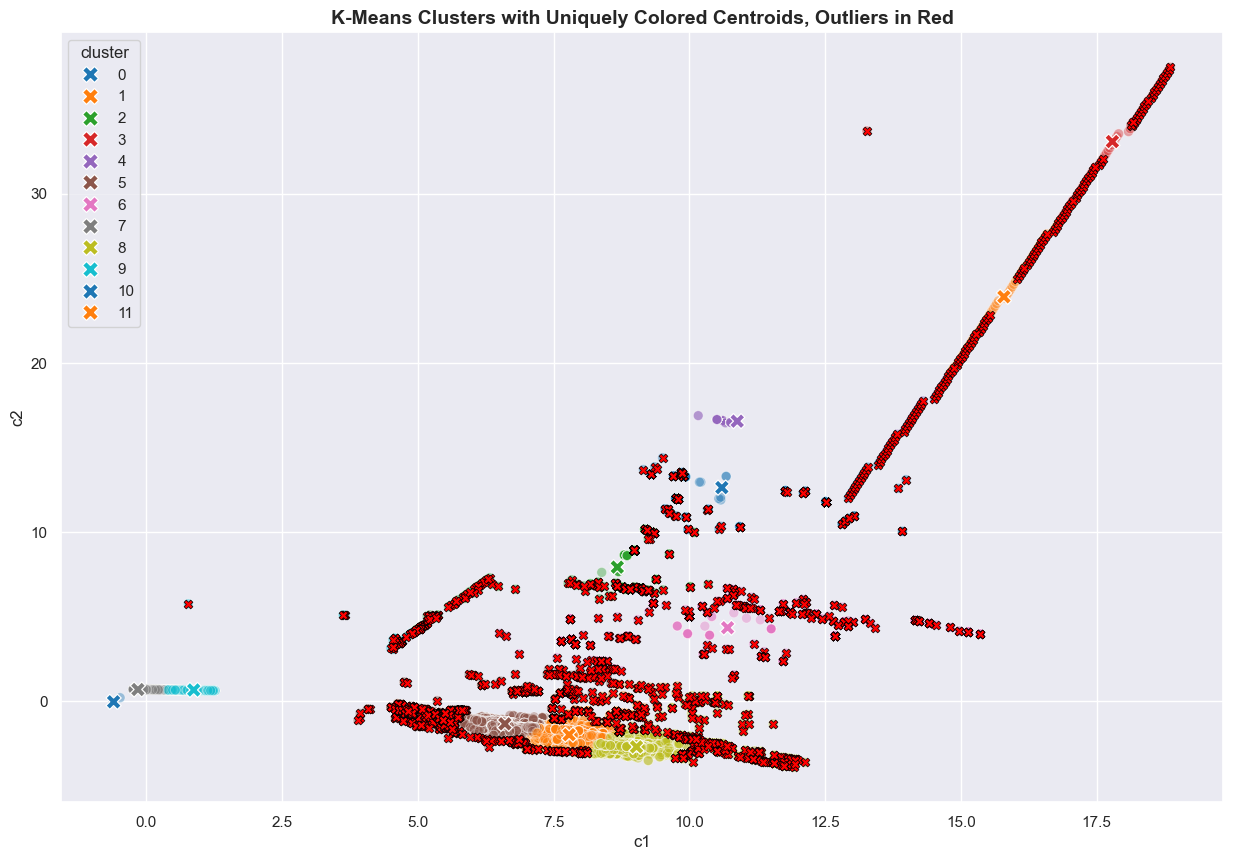

In [39]:
# pd.plotting.parallel_coordinates(KX2, 'cluster')
# KX -- cluster center
# s (square) = outlier
# use Seaborn's scatterplot function to plot the c1 and c2 columns
# from DataFrame kmeans_input. The hue parameter is set to kmeans.labels_, 
# which are the labels assigned by a k-means clustering algorithm, 
# thereby coloring each point according to its cluster label.

ax = sns.scatterplot(
    x=kmeans_input['c1'],
    y=kmeans_input['c2'],
    hue=kmeans.labels_,
    palette='tab10',     # or tab20 if K > 10
    alpha=0.4,
    s=50,
    legend=False        # important: avoid legend overload
)

# plot the centers of the clusters. The centers are accessed via kmeans.cluster_centers_,
# and hue=range(K) assigns a unique color to each center. The centers are plotted 
# with a larger size (s=80) and a different marker style (marker='KX')
centers_df = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=['c1', 'c2']
)
centers_df['cluster'] = centers_df.index.astype(str)

sns.scatterplot(
    data=centers_df,
    x='c1',
    y='c2',
    hue='cluster',
    palette='tab10',   # or 'tab20' if K > 10
    marker='X',
    s=120,
    legend='full',
    ax=ax
)
# Anomalies are plotted with distinctive styling to make them stand out: 
# red color, square markers (marker='s'), larger size (s=40), and 
# a black edge (edgecolor='black').
sns.scatterplot(
    x=x_anom,
    y=y_anom,
    color="red",
    s=40,
    marker="X",
    edgecolor="black",
    legend=False,
    ax=ax
)
ax.set_title(
    "K-Means Clusters with Uniquely Colored Centroids, Outliers in Red",
    fontsize=14,
    fontweight="bold"
);

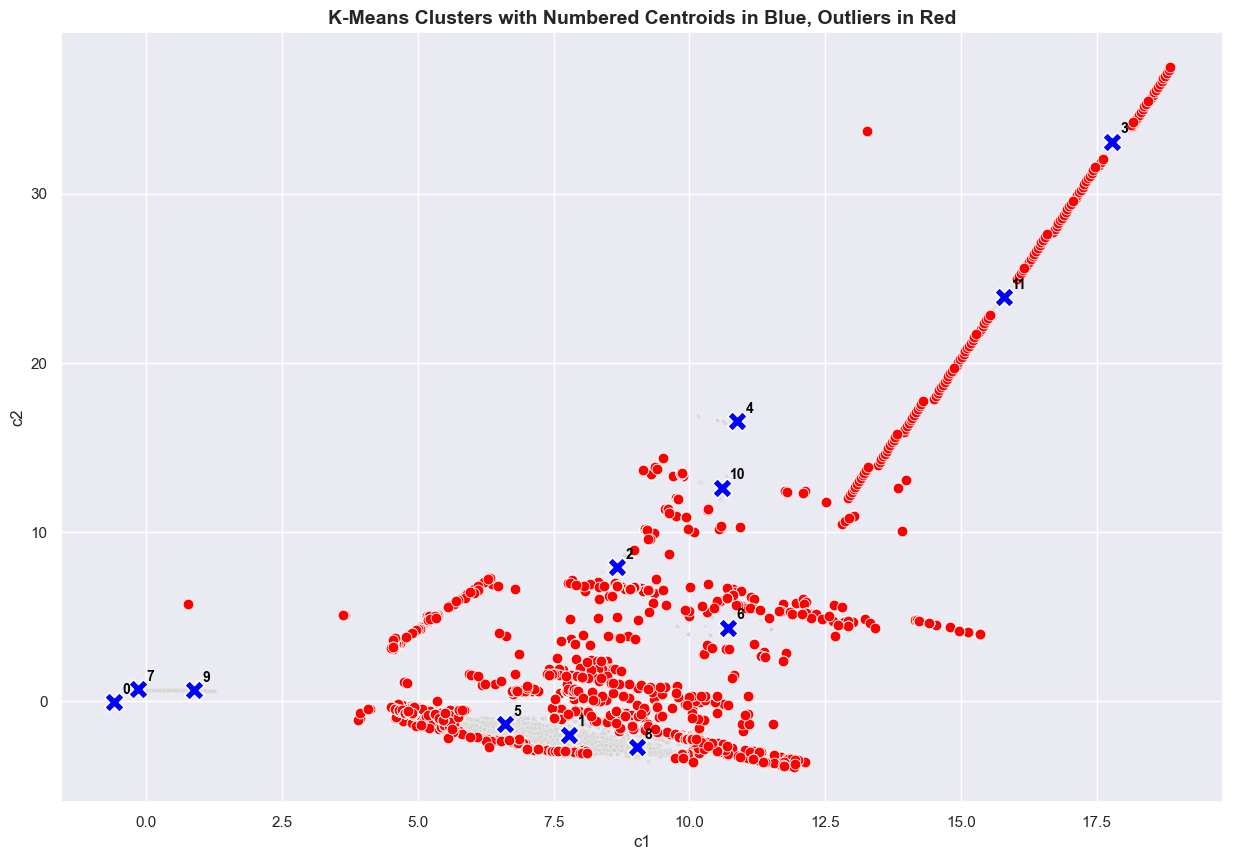

In [40]:
# alternative plot with numbered centers - may be more readable
# than a conventional legend with a lot of centers

ax = sns.scatterplot(
    x=kmeans_input['c1'],
    y=kmeans_input['c2'],
    color="lightgray",
    alpha=0.4,
    s=10
)
# Plot cluster centers
sns.scatterplot(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    color="blue",
    marker="X",
    s=200,
    ax=ax
)
sns.scatterplot(
    x=kmeans_input.loc[idx, 'c1'],
    y=kmeans_input.loc[idx, 'c2'],
    color="red",
    s=60,
    ax=ax
)
# Number the centers
for i, (cx, cy) in enumerate(kmeans.cluster_centers_):
    ax.annotate(
        str(i),
        (cx, cy),
        xytext=(6, 6),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
        color="black"
    )
ax.set_title(
    "K-Means Clusters with Numbered Centroids in Blue, Outliers in Red",
    fontsize=14,
    fontweight="bold"
)
plt.show()

In [41]:
# Normalize outlier_kmeans: force numeric 0/1, anything else -> NaN
kmeans_input['outlier_kmeans'] = pd.to_numeric(kmeans_input['outlier_kmeans'], errors='coerce')

print("dtype after numeric coercion:", kmeans_input['outlier_kmeans'].dtype)
print(kmeans_input['outlier_kmeans'].value_counts(dropna=False))

dtype after numeric coercion: int64
outlier_kmeans
0    321951
1      3253
Name: count, dtype: int64


In [ ]:
# scored anomalies in the encoded dataframe
# scored rows (encoded kmeans_input)
kmeans_anomalies_scored = kmeans_input[kmeans_input['outlier_kmeans'] == 1][['eventID', 'outlier_kmeans'] ].copy()

# list of GUIDs that were flagged
kmeans_anomalous_eventids = kmeans_anomalies_scored['eventID'].unique()

# pull original CloudTrail rows based on GUIDs
raw_kmeans = pd.read_parquet("cloudtrail-300.parquet")  # Adjust the encoding if needed
kmeans_output = raw_kmeans[raw_kmeans['eventID'].isin(kmeans_anomalous_eventids)].copy()

# optional: keep rank and votes attached by merging back on eventid
kmeans_output = kmeans_output.merge(
    kmeans_input[['eventID', 'outlier_kmeans']],
    on='eventID',
    how='left',
    suffixes=('', '_score')
)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None)
kmeans_output

In [43]:
# check that the event IDs match between the raw_kmeans and scored data rows
kmeans_ts_check = (
    raw_kmeans[['eventID', 'eventTime']]
    .merge(
        kmeans_output[['eventID', 'eventTime']],
        on='eventID',
        how='inner',
        suffixes=('_raw_kmeans', '_kmeans_output')
    )
)

# compare timestamps
kmeans_ts_check['eventID_match'] = (
    kmeans_ts_check['eventTime_raw_kmeans'] == kmeans_ts_check['eventTime_kmeans_output']
)

# count matches
kmeans_tmatch_counts = kmeans_ts_check['eventID_match'].value_counts()

num_correct = kmeans_tmatch_counts.get(True, 0)
num_incorrect = kmeans_tmatch_counts.get(False, 0)

print(f"Timestamp matches   : {num_correct}")
print(f"Timestamp mismatches: {num_incorrect}")
print(f"Total compared      : {num_correct + num_incorrect}")

# sanity check (optional)
if num_incorrect > 0:
    print("WARNING: There are mismatched timestamps")

# we are done with raw_kmeans — free memory
#del raw_kmeans
#print('deleted the raw_kmeans dataframe to free memory.')


Timestamp matches   : 3283
Timestamp mismatches: 0
Total compared      : 3283


In [44]:
from threadpoolctl import threadpool_info
threadpool_info()


[{'user_api': 'blas',
  'internal_api': 'openblas',
  'num_threads': 4,
  'prefix': 'libscipy_openblas',
  'filepath': 'D:\\.venv\\Lib\\site-packages\\numpy.libs\\libscipy_openblas64_-9e3e5a4229c1ca39f10dc82bba9e2b2b.dll',
  'version': '0.3.30',
  'threading_layer': 'pthreads',
  'architecture': 'SkylakeX'},
 {'user_api': 'blas',
  'internal_api': 'openblas',
  'num_threads': 4,
  'prefix': 'libscipy_openblas',
  'filepath': 'D:\\.venv\\Lib\\site-packages\\scipy.libs\\libscipy_openblas-64eda39e79589aedb16f58e5547eb599.dll',
  'version': '0.3.30',
  'threading_layer': 'pthreads',
  'architecture': 'SkylakeX'},
 {'user_api': 'openmp',
  'internal_api': 'openmp',
  'num_threads': 4,
  'prefix': 'vcomp',
  'filepath': 'D:\\.venv\\Lib\\site-packages\\sklearn\\.libs\\vcomp140.dll',
  'version': None}]

In [45]:
import time
from sklearn.cluster import KMeans

t0 = time.perf_counter()
kmeans = KMeans(n_clusters=K, random_state=42).fit(KX2)
print(f"Actual runtime: {time.perf_counter() - t0:.2f}s")


Actual runtime: 0.57s
